# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.8 MB/s 
     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 33.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=9141e0850bb0c91ce691bf4dcdc5d11a2f0c7a387a79944c7841bf3ffce6c786
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=f58964a1f39ad9e5d7fb6586e5fbe30d88cb72f874fa61d4e6a3d7afa9bc03a6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

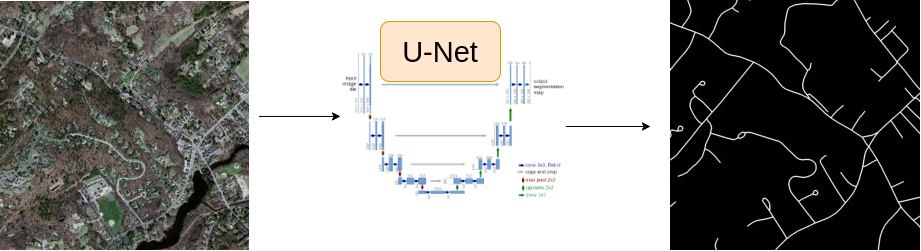

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 35.53 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATDA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head(5)

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 10

row = df.iloc[idx]

image_path = DATDA_DIR + row.images
mask_path = DATDA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

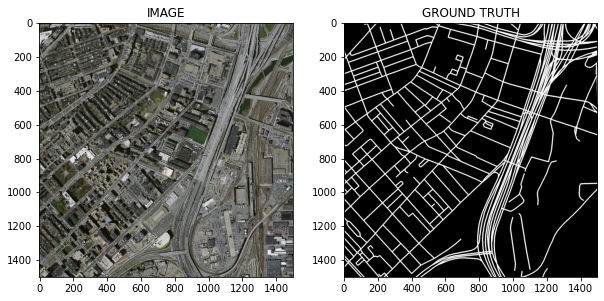

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
len(train_df), len(valid_df)

(159, 40)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
  ])  # do not flip since it needs to flip along with train set

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
      self.df = df
      self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
      row = self.df.iloc[idx]

      image_path = DATDA_DIR + row.images
      mask_path = DATDA_DIR + row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # (h, w, c)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w)
      mask = np.expand_dims(mask, axis=-1)  # (h, w, c)

      if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image'] # (h, w, c)
        mask = data['mask']
      
      # shift (h, w, c) -> (c, h, w) since we use PyTorch
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
      
      # convert to Tensor
      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

      return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
len(trainset), len(validset)

(159, 40)

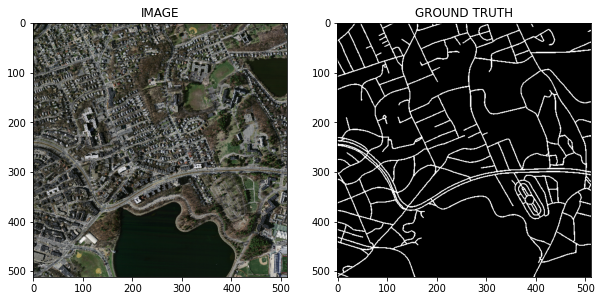

In [ ]:
idx = 9

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 20
total no. of batches in validloader : 5


In [ ]:
for image, mask in trainloader:
  print(f'One batch image shape : {image.shape}')
  print(f'One batch mask shape : {mask.shape}')
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    
    self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None # output will be raw
    )
  
  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train() # to turn ON dropout, batchnorm, etc.
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward() # calc gradient
    optimizer.step()  # update parameters

    total_loss += loss.item()
  
  return total_loss / len(data_loader)  # divide by number of batch

In [ ]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print('Epoch: %d -- train_loss: %f -- valid_loss: %f'%(i+1, train_loss, valid_loss))

100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


SAVED-MODEL
Epoch: 1 -- train_loss: 1.104765 -- valid_loss: 1.035752


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED-MODEL
Epoch: 2 -- train_loss: 0.755408 -- valid_loss: 0.906702


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


SAVED-MODEL
Epoch: 3 -- train_loss: 0.698266 -- valid_loss: 0.746288


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED-MODEL
Epoch: 4 -- train_loss: 0.661526 -- valid_loss: 0.717088


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED-MODEL
Epoch: 5 -- train_loss: 0.662781 -- valid_loss: 0.681735


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED-MODEL
Epoch: 6 -- train_loss: 0.636755 -- valid_loss: 0.658907


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch: 7 -- train_loss: 0.633201 -- valid_loss: 0.698515


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 8 -- train_loss: 0.623665 -- valid_loss: 0.663154


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED-MODEL
Epoch: 9 -- train_loss: 0.616535 -- valid_loss: 0.648569


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Epoch: 10 -- train_loss: 0.612517 -- valid_loss: 0.677057


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 11 -- train_loss: 0.607456 -- valid_loss: 0.653828


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 12 -- train_loss: 0.597080 -- valid_loss: 0.665016


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 13 -- train_loss: 0.597914 -- valid_loss: 0.652238


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 14 -- train_loss: 0.589808 -- valid_loss: 0.664961


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


SAVED-MODEL
Epoch: 15 -- train_loss: 0.594315 -- valid_loss: 0.628015


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 16 -- train_loss: 0.577861 -- valid_loss: 0.632434


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 17 -- train_loss: 0.578487 -- valid_loss: 0.704725


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 18 -- train_loss: 0.579666 -- valid_loss: 0.639777


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 19 -- train_loss: 0.575882 -- valid_loss: 0.644703


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 20 -- train_loss: 0.567744 -- valid_loss: 0.643311


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch: 21 -- train_loss: 0.579761 -- valid_loss: 0.650066


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED-MODEL
Epoch: 22 -- train_loss: 0.565007 -- valid_loss: 0.627532


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED-MODEL
Epoch: 23 -- train_loss: 0.564756 -- valid_loss: 0.617288


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch: 24 -- train_loss: 0.553641 -- valid_loss: 0.632119


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

SAVED-MODEL
Epoch: 25 -- train_loss: 0.552548 -- valid_loss: 0.588803


# Task 9 : Inference

In [ ]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (c, h, w) -> (b, c, h, w) ~ batch_size(b)=1
pred_mask = torch.sigmoid(logits_mask)
pre_mask = (pred_mask > 0.5)*1.0

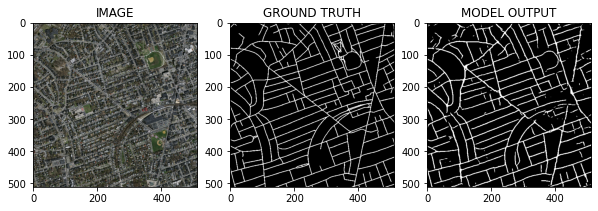

In [ ]:
helper.show_image(image, mask, pre_mask.detach().cpu().squeeze(0))

In [ ]:
import timm
timm.list_models('*')

['adv_inception_v3',
 'bat_resnext26ts',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2n

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

